In [1]:
import numpy as np
import math
import scipy.stats as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import time
import ipywidgets as wg
import IPython
from IPython.display import HTML, display, clear_output

import networkx as nx
import graphviz
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import pickle
from astropy import stats
from joblib import Parallel, delayed

# General function definitions

In [2]:
def specific_heat(x):
    ''' Calculates specific heat.
        
        Parameters: 
            x: dtype numpy array
                One dimensional array containing the energy data (or equivalent quantity)
            
        Returns: dtype numpy array
            One dimensional array containing the specific heat data'''
    
    cv = (np.var(x))/(T**2)
    return(cv)

In [3]:
def susceptiblity(mag):
    ''' Calculates specific heat.
        
        Parameters: 
            mag: dtype numpy array
                One dimensional array containing the magnetization data
            
        Returns: dtype numpy array
            One dimensional array containing the susceptibility data'''
    
    susc = (np.var(mag))/T
    return(susc)

# Network function definitions

In [4]:
def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map: dtype numpy array
                [N] boolean array containing True if bond is present or False if not. For example spin lattice [1, -1, 1, 1]
                corresponds to f_map [True, True, False, False]
    """
    lat = np.array(lat)
    a = lat[1:]-lat[0:len(lat)-1]; b = lat[0]-lat[len(lat)-1]
    c = np.append(a,b)
    f_map = (c == 0)
    return(f_map)

In [5]:
def backtrack(x,vis,fm,cl):
    """ Part of the cluster decomposition. It recursively checks whether neighbouring spin should be added to the cluster
    """
    if not vis[x]:
        vis[x] = True
        cl.append(x)
        if fm[x]:
            vis, cl = backtrack((x+1)%len(fm),vis,fm,cl)
        if fm[(x-1)%len(fm)]:
            vis, cl = backtrack((x-1)%len(fm),vis,fm,cl)
    return(vis,cl)

In [6]:
def cluster_decomp(lat):
    """ Decomposes the spin lattice into clusters, i.e. creates list of cluster arrays. A cluster array contains the indices of 
        the spins in a cluster
        
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
                
        Returns:
            cls: dtype list
                list of cluster arrays. Each cluster array contains the indices of the spins in that cluster
    """
    visited = np.full((len(lat)), False)
    frozen_map = create_frozen_map(lat)
    #zeros = np.where(np.array(lat)==0)[0]
    #tried = dict.fromkeys(zeros,False)
    cls = []
    for i in range(len(lat)):
        clu = []
        visited, clu = backtrack(i,visited,frozen_map,clu)
        if len(clu) > 0:
            cls.append(clu)
    return(cls)

In [7]:
def create_boundary_graph(lat):
    """ Create boundary graph (collection of nodes) corresponding to the spin lattice
    
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns: 
            bdGr: dtype networkx graph
                boundary graph 
    """
    n_nodes = len(lat)
    bdGr = nx.Graph()
    for i in range(N):
        bdGr.add_node(i)
    return(bdGr)

In [8]:
def construct_graph(lat,bdGr):
    """ Construct graph from spin lattice according to the AoSD procedure
        
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
            bdGr: dtype networkx graph
                graph containing the boundary nodes (i.e. as constructed by the function 'create_boundary_graph')
            
        Returns: 
            Gr: dtype networkx graph
                AoSD graph 
    """
    lats = []; lats.append(lat)
    shell = 0; n_nodes_shell = len(np.array(lats[shell])); add = 0
    Gr = bdGr.copy()
    CGP_step1 = True
    n_col = 0; n_col_norm = 0
    while(n_nodes_shell>1):
        new_lat = []
        if CGP_step1:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                for j in clusters[i]:
                    value += lats[shell][j]
                    Gr.add_edge(n_Gr,j+add)
                new_lat.append(value)
            CGP_step1 = False
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            for k in np.arange(0,n_nodes_shell,2):
                n_col_norm += 1
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                #print('n_Gr', n_Gr)
                #print('k',k+add)
                value = lats[shell][k]+lats[shell][k+1]
                if value == 0:
                    value = 1#np.random.choice([-1,1])
                    n_col += 1
                else:
                    value = value/abs(value)
                Gr.add_edge(n_Gr,k+add); Gr.add_edge(n_Gr,k+1+add)
                new_lat.append(value)
            CGP_step1 = True
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = len(np.array(lats[shell]))
    return(Gr, n_col, n_col_norm)

In [9]:
def construct_graph_eff(lat):
    lats = []; lats.append(lat)
    shell = 0; n_nodes_shell = len(np.array(lats[shell])); add = 0
    n_Gr = n_nodes_shell
    CGP_step1 = True
    n_col = 0; n_col_norm = 0 # number of collisions when random tie breaker is used
    while(n_nodes_shell>1):
        new_lat = []
        if CGP_step1:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr += 1#nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                for j in clusters[i]:
                    value += lats[shell][j]
                    #Gr.add_edge(n_Gr,j+add)
                new_lat.append(value)
            CGP_step1 = False
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            for k in np.arange(0,n_nodes_shell,2):
                n_col_norm += 1
                value = 0
                n_Gr += 1#nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                #print('n_Gr', n_Gr)
                #print('k',k+add)
                value = lats[shell][k]+lats[shell][k+1]
                if value == 0:
                    value = 1#np.random.choice([-1,1])
                    n_col += 1
                else:
                    value = value/abs(value)
                #Gr.add_edge(n_Gr,k+add); Gr.add_edge(n_Gr,k+1+add)
                new_lat.append(value)
            CGP_step1 = True
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = len(np.array(lats[shell]))
    return(n_Gr, n_col, n_col_norm)

In [10]:
def network_energy_calc(nGr):
    Enw = nGr-2*N
    return(Enw)

# Metropolis function definitions

In [11]:
def metropolis(lat,G,bdG,Enw,M,n_col,n_col_norm, Tl):
    ''' Implement metropolis algorithm for a single spin flip with probability given by the number of nodes of network that 
        corresponds to the lattice 
    
        Parameters: 
            lat: dtype numpy array
                [N] array representing the lattice
            Enw: dtype float or int
                Energy will be given by the number of nodes of the network corresponding to the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L):
    x = np.random.randint(0,N)
    trial_lat = np.copy(lat)
    trial_lat[x] *= -1
    # Construct corresponding network:
    trialG, trial_col, trial_col_norm = construct_graph(trial_lat,bdG.copy())
    # Calculate energy difference between the old and trial configurations:
    trialEnw = network_energy_calc(nx.number_of_nodes(trialG))
    dEnw = trialEnw - Enw
    # Implement second stage of the metropolis algorithm:
    if dEnw <= 0:
        Enw = Enw + dEnw
        M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
        lat[x] = trial_lat[x]
        G = trialG; n_col = trial_col; n_col_norm = trial_col_norm
    else:
        r = np.random.uniform(0,1)
        p=np.exp(-dEnw/Tl)#p = exp[0]
        if r < p:
            Enw = Enw + dEnw
            M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
            lat[x] = trial_lat[x]
            G = trialG; n_col = trial_col; n_col_norm = trial_col_norm
    return(lat,G,Enw,M,n_col,n_col_norm)

In [12]:
def metropolis_eff(lat,Enw,M,n_col,n_col_norm,Tl):
    ''' Implement metropolis algorithm for a single spin flip with probability given by the number of nodes of network that 
        corresponds to the lattice 
    
        Parameters: 
            lat: dtype numpy array
                [N] array representing the lattice
            Enw: dtype float or int
                Energy will be given by the number of nodes of the network corresponding to the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L):
    x = np.random.randint(0,N)
    trial_lat = np.copy(lat)
    trial_lat[x] *= -1
    # Construct corresponding network:
    trial_nGr, trial_col, trial_col_norm = construct_graph_eff(trial_lat)
    trialEnw = network_energy_calc(trial_nGr)
    # Calculate energy difference between the old and trial configurations:
    dEnw = trialEnw - Enw
    # Implement second stage of the metropolis algorithm:
    if dEnw <= 0:
        Enw = Enw + dEnw
        M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
        lat[x] = trial_lat[x]
        n_col = trial_col; n_col_norm = trial_col_norm
    else:
        r = np.random.uniform(0,1)
        p=np.exp(-dEnw/Tl)#p = exp[0]
        if r < p:
            Enw = Enw + dEnw
            M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
            lat[x] = trial_lat[x]
            n_col = trial_col; n_col_norm = trial_col_norm
    return(lat,Enw,M,n_col,n_col_norm)

# Exhibition

In [13]:
def exhibition(temp, save):
    t_sim = 10
    #global T
    #T = temp
    #global exp
    #exp = np.array([np.exp(-4/T),1,np.exp(4/T)]) # Store possible values of the acceptance probability (only need first value for metropolis)
    #global A_wolff
    #A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
    # Initialize lattice
    lattice = -1*np.ones(N) 
    #lattice = np.random.choice([1,-1],size=(N))

    # Initialize figure
    %matplotlib notebook
    fig = plt.figure(figsize=(10,5)); plt.axis('off'); plt.title('N=%d, T=%.1f'%(N,temp))
    #cur_axes = plt.gca()#cur_axes.axes.get_xaxis().set_visible(False)#cur_axes.axes.get_yaxis().set_visible(False)
    #for spine in plt.gca().spines.values():#   spine.set_visible(False)#plt.figtext(0.9, 0.05, '$x$')#fig.text(0.5,-0.5,'S')#plt.title('N = %d, T = %d'%(temp,N))
    ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
    ax1.set_axis_off()

    # Initialize boundary graph
    bdG = create_boundary_graph(lattice)
    # Construct graph:
    graph, col, col_norm = construct_graph(lattice,bdG)
        
    # Calculate network energy and magnetisation 
    Enw = network_energy_calc(nx.number_of_nodes(graph)); M = np.sum(lattice) 

    for j in range(t_sim):
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lattice, graph, Enw, M, col, col_norm = metropolis(lattice,graph,bdG,Enw,M,col,col_norm, temp)
            
        # Perform cluster flip using wolff algorithm:
        #lattice, E, M = Wolff(lattice,E,M)     
        
        # Draw boundary graph
        nx.draw_networkx(bdG,pos=nx.circular_layout(bdG),with_labels=True,node_color=lattice,ax=ax1,font_size=10)#,cmap=plt.cm.GnBu,vmin=-2,vmax=2)
        
        # Draw bulk graph
        ax2.clear(); ax2.set_axis_off()
        #graph, col, col_norm = construct_graph(lattice,bdG.copy())
        pos=graphviz_layout(graph,prog='twopi')
        nx.draw_networkx(graph,pos=pos,with_labels=True,ax=ax2,node_size=20,font_size=8, node_color= 'r')
    
        fig.canvas.draw()
        #time.sleep(0.1)
        
    if save:
        plt.savefig('nwp1DcorrespondenceN=%dT=%d'%(N,temp))
    #nx.write_gml(graph,'howtree.gml')

In [14]:
N = 20
wg.interact_manual(exhibition, temp=(0.1,100), save=False)

interactive(children=(FloatSlider(value=50.050000000000004, description='temp', min=0.1), Checkbox(value=False…

<function __main__.exhibition(temp, save)>

# Results

In [15]:
def simulate(lat, Tl):
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en_nw = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy Enw and magnetisation M 
    graphs = [] # list to store (bulk)graphs corresponding to the lattice during simulation
    col = 0; col_norm = 0 # Floats to count number of 'collisions' and total number of possible collisions in averaging procedure
    
    # Initialize boundary graph
    bdG = create_boundary_graph(lat)
        
    # Create bulk graph
    graph, Ncol, Ncol_norm = construct_graph(lat,bdG)
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    Enw = network_energy_calc(nx.number_of_nodes(graph)); M = np.sum(lat)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en_nw[j] = Enw; mag[j] = M
        graphs.append(graph)
        col += Ncol; col_norm += Ncol_norm
        
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lat, graph, Enw, M, Ncol, Ncol_norm = metropolis(lat,graph,bdG,Enw,M,Ncol,Ncol_norm, Tl)
            
        # Perform cluster flip using wolff algorithm:
        #lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        #graph, Ncol, Ncol_norm = construct_graph(lat,bdG.copy())
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en_nw, mag, graphs, col, col_norm)

In [16]:
def simulate_eff(lat, Tl):
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en_nw = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy Enw and magnetisation M 
    col = 0; col_norm = 0 # Floats to count number of 'collisions' and total number of possible collisions in averaging procedure
    
    # Create bulk graph
    nGr, Ncol, Ncol_norm = construct_graph_eff(lat)
    Enw = network_energy_calc(nGr)
    
    # Calculate magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    M = np.sum(lat)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en_nw[j] = Enw; mag[j] = M
        col += Ncol; col_norm += Ncol_norm
        
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lat, Enw, M, Ncol, Ncol_norm = metropolis_eff(lat,Enw,M,Ncol,Ncol_norm, Tl)
            
        # Perform cluster flip using wolff algorithm:
        #lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        #N_nodes, Ncol, Ncol_norm = construct_graph_eff(lat)
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en_nw, mag, col, col_norm)

# Free energy

In [17]:
def exc_free_energy_calc():
    f = np.zeros(len(temperatures))
    for i,T in enumerate(temperatures):
        f[i] = -T*np.log(2*np.cosh(1/T))
    return f

In [18]:
def create_energy_hist(x, mode):
    lowB = np.min(x)
    upperB = np.max(x)
    if mode == 'nng':
        n = round(abs(upperB-lowB)*0.19)+2   
    else:
        n = round(abs(upperB-lowB)*50)+2
    bin_edges = np.linspace(lowB,upperB,n)
    print(n)
    #bin_edges = np.histogram_bin_edges(en, bins='doane')
    h, b = np.histogram(x, bins=bin_edges)#, density=True)
    #h, b = stats.histogram(x, bins='blocks')
    idx = np.where(h>0)
    h = h[idx]
    b = b[idx]
    return h, b
    

In [19]:
def free_energy_calc(nE, en, g, temp):
    f = -temp*np.log(g/nE) + en
    return f

In [20]:
def g_transfer(nE1, en1, g1, nE2, en2, temp):
    g2 = round(g1*(nE2/nE1)*np.exp(-(1/temp)*(en1-en2)))
    return g2

In [21]:
def find_intersection(x_targ, y_targ, x2, y2):
    m = len(x_targ)
    n = len(x2)
    min_dist = 10000
    coords = np.zeros((2,2))
    for i in range(m):
        for j in range(n):
            d = (x2[j]-x_targ[i])**2 + (y2[j]-y_targ[i])**2
            if d < min_dist:
                min_dist = d
                coords[0][0] = x_targ[i]
                coords[0][1] = y_targ[i]
                coords[1][0] = x2[j]
                coords[1][1] = y2[j]
    return(coords)

In [22]:
def free_energyVStemp(hists, bins, g0):
    f = np.zeros(len(temperatures))
    idx = np.argmax(hists[0])
    nE = hists[0][idx]
    en = bins[0][idx]
    g = g0
    
    for i,temperature in enumerate(temperatures):
        #print('g',g)
        f[i] = free_energy_calc(nE, en, g, temperature)   
        
        if i == (len(temperatures)-1):
            break
        #print(i)
        hist1 = hists[i]
        bins1 = bins[i]
        hist2 = hists[i+1]
        bins2 = bins[i+1]
        l = np.argmax(hist1)
        k = np.argmax(hist2)+1
        #print('l:', l, 'k:', k)
        if bins2[k-1] < bins1[l]:
            raise ValueError('Data of consecutive histograms %d and %d are not consecutive'%(i,i+1))
          
        # get intersection
        coords = find_intersection(bins1[l:], hist1[l:], bins2[:k], hist2[:k])
        
        en1 = coords[0][0]
        nE1 = coords[0][1]
               
        g = g_transfer(nE, en, g, nE1, en1, temperature)
        #print(coords)
        en = coords[1][0]
        nE = coords[1][1]  
    return f
            

In [23]:
def check_visual(i, hists, bins):

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    
    b1 = bins[i]
    h1 = hists[i]
    print(b1)
    l = np.argmax(h1)
    temperature1 = temperatures[i]
    
    b2 = bins[i+1]
    h2 = hists[i+1]
    k = np.argmax(h2)+1
    temperature2 = temperatures[i+1]
    
    ax.plot(b1/N, h1,label='T=%.2f'%(temperature1), markersize=3, linestyle='-', marker='o', linewidth=1, color='#1f77b4')
    ax.plot(b1[l:]/N, h1[l:], markersize=6, color='#1f77b4', marker='o', linewidth=2)
    
    ax.plot(b2/N, h2,label='T=%.2f'%(temperature2), markersize=3, linestyle='-', marker='o', linewidth=1, color='orange')
    ax.plot(b2[:k]/N, h2[:k], markersize=6, color='orange', marker='o', linewidth=2)
    
    ax.legend()
    #ax5.set_yscale('log')

### Equilibrium for Free Energy

In [24]:
lowRange = np.arange(0.1, 1.1, 0.095)
highRange = np.geomspace(1.1, 6, 14)
temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

new = False
if new:
    possibleScales = []
    LinitC = []; Len_nw_data = []
    Lmag_data= []; t_sim = 0
    
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Lmag_data': Lmag_data, 
                 'Len_nw_data': Len_nw_data, 'LinitC': LinitC}
    
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergySpec.p', 'wb'))

25
[0.1        0.195      0.29       0.385      0.48       0.575
 0.67       0.765      0.86       0.955      1.05       1.1
 1.25333284 1.42803929 1.62709868 1.85390565 2.11232804 2.40677283
 2.74226131 3.12451469 3.56005172 4.05629977 4.62172157 5.2659595
 6.        ]


In [25]:
run = False
# Set system parameters (note that these are global!):
N = 784 # Lattice number
#temperatures = np.geomspace(0.1, 4, 6) # Temperature (critical at around 0.2)
t_eq = 1000
t_prod = 0
t_sim = t_eq + t_prod


mag_data = []
en_nw_data = []
initC = []

lattice = np.ones(N)

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, _, _ = simulate_eff(lattice, T)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        initC.append(lattice)
    
        mag_data.append(abs(M))
        en_nw_data.append(Enw)

In [27]:
nwpEqDataF = pickle.load(open('nwp1DeqDataFreeEnergySpec.p', 'rb'))
possibleScales = nwpEqDataF['possibleScales']; temperatures = nwpEqDataF['temperatures']
Len_nw_data = nwpEqDataF['Len_nw_data']; Lmag_data = nwpEqDataF['Lmag_data']
LinitC = nwpEqDataF['LinitC']


save = False
if save:
    possibleScales.append(N)
    Len_nw_data.append(en_nw_data); Lmag_data.append(mag_data)
    LinitC.append(initC); 
    
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergySpec.p', 'wb'))

In [28]:
idx = 2
print(Lmag_data[idx][13][-1])
print(np.sum(LinitC[idx][13]))

82.0
82.0


In [29]:
idx = 2
L = possibleScales[idx]
print(LinitC[idx][0])
print(np.where(LinitC[idx][0]!=np.ones(L)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

possibleScales:  [64, 256, 784, 1024]


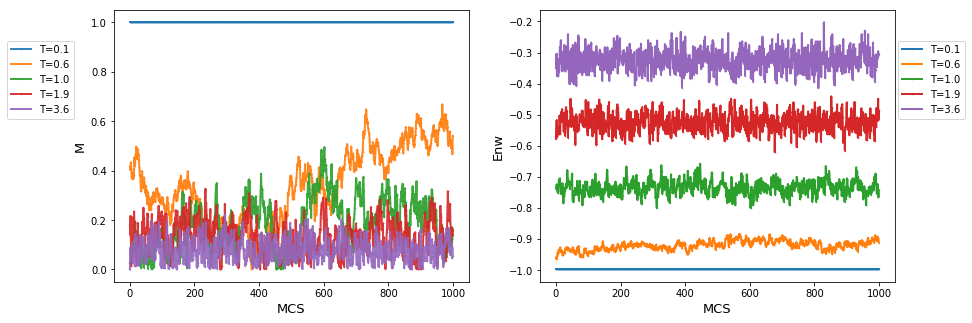

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
save = False
idx = 2

if not save:
    nwpEqDataF = pickle.load(open('nwp1DeqDataFreeEnergySpec.p', 'rb'))
    t_sim = nwpEqDataF['t_sim']; possibleScales = nwpEqDataF['possibleScales']; Lmag_data = nwpEqDataF['Lmag_data']
    Len_nw_data = nwpEqDataF['Len_nw_data']; temperatures = nwpEqDataF['temperatures']

print('possibleScales: ', possibleScales)    
    
t = np.arange(t_sim)
step = 5

for i, item in enumerate(temperatures[::step]):
    ax1.plot(t,Lmag_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,Len_nw_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('Enw', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6))


if save:
    plt.savefig('nwp1DequitimeF')
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergySpec.p', 'wb'))

### Free Energy Simulation

In [31]:
#lowRange = np.geomspace(0.1, 3, 22, endpoint=False)
#highRange = np.linspace(3.2, 6, 3)
#temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

f_exact = exc_free_energy_calc()


new = False
if new:
    scales = []
    Len_nw_data = []; Len_nw_err = []
    Len_nw_hist_data = []; Len_nw_bin_edges_data = []
    Len_nw_fr = []; Len_nwS = []
    

    # Save data as dictionary:
    nwpLf_data = {'f_exact': f_exact, 'Len_nw_fr': Len_nw_fr, 'Len_nwS': Len_nwS, 'Len_nw_data': Len_nw_data, 
                  'Len_nw_err': Len_nw_err, 'Len_nw_hist_data': Len_nw_hist_data, 
                  'Len_nw_bin_edges_data': Len_nw_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(nwpLf_data, open('nwp1Dfree_energy_finite_size_scalingSpec.p', 'wb'))
    

25
[0.1        0.195      0.29       0.385      0.48       0.575
 0.67       0.765      0.86       0.955      1.05       1.1
 1.25333284 1.42803929 1.62709868 1.85390565 2.11232804 2.40677283
 2.74226131 3.12451469 3.56005172 4.05629977 4.62172157 5.2659595
 6.        ]


In [32]:
# Set system parameters (note that these are global!):
#scales = [256, 784, 1024] # Lattice number
#low_range = np.linspace(0.1, 3, 20); high_range = np.linspace(3.5, 6, 5)
#temperatures = np.concatenate((low_range, high_range))
#temperatures = np.linspace(0.1, 5, 25) # Temperature (critical at around 2.27)
#temperatures = np.arange(0.1, 6, 0.19)

run = False

if run:
    N = 64; idx = 0
    t_eq = 1000
    t_prod = 20000
    t_sim = t_eq + t_prod
    
    en_nw_data = np.zeros(len(temperatures)); en_nw_err = np.zeros(len(temperatures))
    en_nw_hist_data = []; en_nw_bin_edges_data = []
    
    # Initial lattice configuration
    lattice = -1*np.ones(N)  
    # lattice = np.random.choice([1,-1],size=(N,N))
  
    results = Parallel(n_jobs=3, verbose=15)(delayed(simulate_eff)(lattice, T) for lattice,T in zip(LinitC[idx], temperatures))
    results1 = np.array(results).T
    
    for i,T in enumerate(temperatures):
        Enw = results1[1][i]
        en_nw_data[i] = np.mean(Enw[t_eq:]); en_nw_err[i] = np.std(Enw[t_eq:])
        
        en_nw_hist, en_nw_bin_edges = create_energy_hist(Enw[t_eq:], 'en')
        en_nw_hist_data.append(en_nw_hist/t_prod); en_nw_bin_edges_data.append(en_nw_bin_edges)

    '''for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        #probability (only need first two values for metropolis)
        #A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, _, _ = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
        
        en_nw_hist, en_nw_bin_edges = create_energy_hist(Enw[t_eq:], 'en')
        
        en_nw_data[j] = np.mean(Enw[t_eq:]); en_nw_err[j] = np.std(Enw[t_eq:])
        
        en_nw_hist_data.append(en_nw_hist/t_prod); en_nw_bin_edges_data.append(en_nw_bin_edges)
    '''

### Visually check histograms

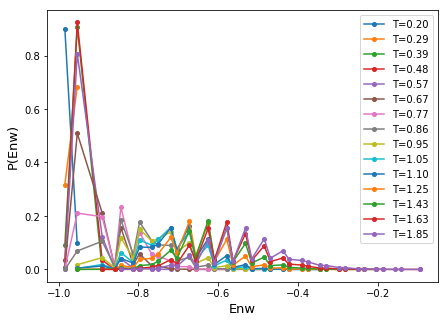

In [67]:
%matplotlib inline
fig5 = plt.figure(figsize=(7,5))
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xlabel('Enw', fontsize=13)
ax5.set_ylabel('P(Enw)', fontsize=13)

l = 1
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax5.plot(en_nw_bin_edges_data[l+i]/N, en_nw_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax5.legend()
#ax5.set_yscale('log')

In [68]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(en_nw_hist_data), bins=wg.fixed(en_nw_bin_edges_data), i=(0,len(temperatures)-2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

<function __main__.check_visual(i, hists, bins)>

### Plot free energy

In [69]:
#f_exact = exc_free_energy_calc()
en_nw_fr = free_energyVStemp(en_nw_hist_data, en_nw_bin_edges_data, 1)
print(en_nw_fr)


[ -63.          -63.02030711  -63.43451829  -64.10312789  -64.85491312
  -65.69410338  -66.77701469  -68.3371375   -70.31164749  -72.61668887
  -75.08773238  -76.47812659  -81.02209314  -86.57675654  -93.35451818
 -101.45374136 -111.01615428 -122.27127116 -135.57778582 -151.06337713
 -169.18099973 -190.16241232 -214.41996078 -242.42299942 -273.95448336]


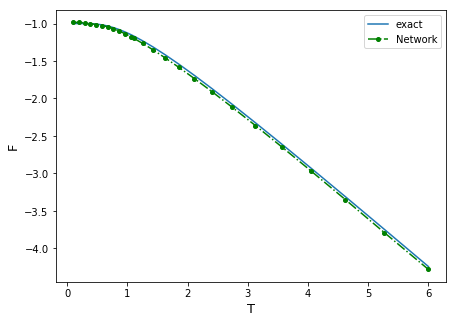

In [70]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1)#; ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('F', fontsize=13)
#ax8.set_ylabel('Network F', fontsize=13, color='g')

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_nw_fr/N, label='Network', linestyle='-.', color='g', marker='o', markersize=4)

ax7.legend()

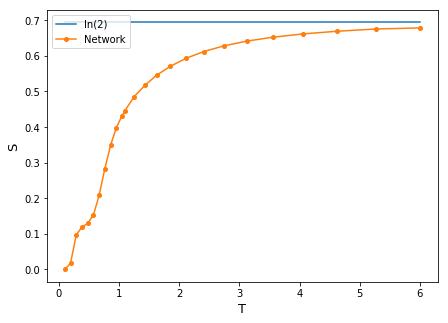

In [71]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('nng S', fontsize=13, color='g')

en_nwS = (en_nw_data-en_nw_fr)/(temperatures)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)), label='ln(2)')
ax.plot(temperatures, en_nwS/N, label='Network', marker='o', markersize=4)


ax.legend(loc='upper left')

In [33]:
nwpLf_data = pickle.load(open('nwp1Dfree_energy_finite_size_scalingSpec.p', 'rb'))
f_exact = nwpLf_data['f_exact']; Len_nw_fr = nwpLf_data['Len_nw_fr']; Len_nwS = nwpLf_data['Len_nwS'] 
Len_nw_data = nwpLf_data['Len_nw_data'] ; Len_nw_err = nwpLf_data['Len_nw_err'] 
Len_nw_hist_data = nwpLf_data['Len_nw_hist_data']; Len_nw_bin_edges_data = nwpLf_data['Len_nw_bin_edges_data']
temperatures = nwpLf_data['temperatures']; scales = nwpLf_data['scales']

save = False
if save:
    scales.append(N)
    Len_nw_fr.append(en_nw_fr); Len_nwS.append(en_nwS)
    Len_nw_data.append(en_nw_data); Len_nw_err.append(en_nw_err)
    Len_nw_hist_data.append(en_nw_hist_data); Len_nw_bin_edges_data.append(en_nw_bin_edges_data)
    
    # Save energy data as dictionary:
    nwpLf_data = {'f_exact': f_exact, 'Len_nw_fr': Len_nw_fr, 'Len_nwS': Len_nwS, 'Len_nw_data': Len_nw_data, 
                  'Len_nw_err': Len_nw_err, 'Len_nw_hist_data': Len_nw_hist_data, 
                  'Len_nw_bin_edges_data': Len_nw_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(nwpLf_data, open('nwp1Dfree_energy_finite_size_scalingSpec.p', 'wb'))
    

In [34]:
print(scales)
print(len(temperatures))

[64, 256, 784, 1024]
25


### Plot free energy for various system size  

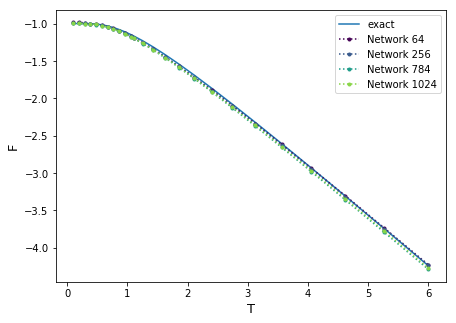

In [35]:
%matplotlib inline

fig8 = plt.figure(figsize=(7,5))
ax8 = fig8.add_subplot(1,1,1)#; ax9 = ax8.twinx()
ax8.set_xlabel('T', fontsize=13)
ax8.set_ylabel('F', fontsize=13)
#ax9.set_ylabel('nng F', fontsize=13)

ax8.plot(temperatures, f_exact, label='exact')

for i,L in enumerate(scales):
    ax8.plot(temperatures, Len_nw_fr[i]/L, label='Network %d'%(L), linestyle=':', color=cm.viridis(i*70), marker='o', 
             markersize=3)
    #ax9.plot(temperatures, Lnng_fr[i]/L, label='nng %d'%(L), linestyle='-', color=cm.viridis(i*70), marker='x', markersize=8)
    
ax8.legend()
#ax9.legend(loc='lower left')

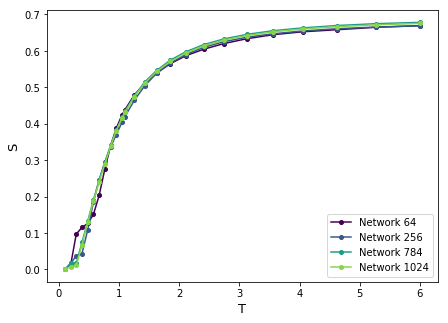

In [36]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('nng S', fontsize=13)

for i,L in enumerate(scales):
    ax.plot(temperatures, Len_nwS[i]/L, color=cm.viridis(i*70), marker='o', markersize=4, label='Network %d'%(L))
    #ax1.plot(temperatures, nng_S, color=cm.viridis(i*70), marker='x', markersize=8)
    
ax.legend()

# Old

### Equilibrium

Set temperatures:

In [16]:
temperatures = np.geomspace(0.1, 8, 34)
print(temperatures)

new = False
if new:
    possibleScales = []
    LinitC = []; Len_nw_data = []
    Lmag_data= []; t_sim = 0
    
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Lmag_data': Lmag_data, 
                 'Len_nw_data': Len_nw_data, 'LinitC': LinitC}
    
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [17]:
run = False
# Set system parameters (note that these are global!):
N = 784 # Lattice number
#temperatures = np.geomspace(0.1, 4, 6) # Temperature (critical at around 0.2)
t_eq = 1000
t_prod = 0
t_sim = t_eq + t_prod


mag_data = []
en_nw_data = []
initC = []

lattice = np.ones(N)

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, _, _ = simulate_eff(lattice, T)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        initC.append(lattice)
    
        mag_data.append(abs(M))
        en_nw_data.append(Enw)

In [18]:
nwpEqData = pickle.load(open('nwp1DeqData.p', 'rb'))
possibleScales = nwpEqData['possibleScales']; temperatures = nwpEqData['temperatures']
Len_nw_data = nwpEqData['Len_nw_data']; Lmag_data = nwpEqData['Lmag_data']
LinitC = nwpEqData['LinitC']


save = False
if save:
    possibleScales.append(N)
    Len_nw_data.append(en_nw_data); Lmag_data.append(mag_data)
    LinitC.append(initC); 
    
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

possibleScales:  [64, 256, 784, 1024]


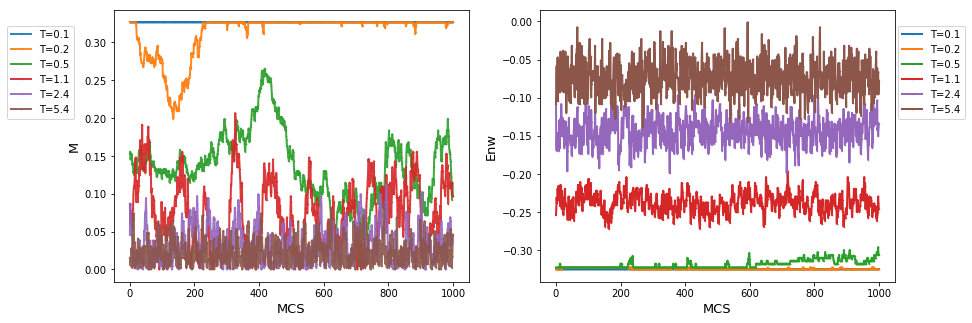

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
save = False
idx = 1


if not save:
    nwpEqData = pickle.load(open('nwp1DeqData.p', 'rb'))
    t_sim = nwpEqData['t_sim']; possibleScales = nwpEqData['possibleScales']; Lmag_data = nwpEqData['Lmag_data']
    Len_nw_data = nwpEqData['Len_nw_data']; temperatures = nwpEqData['temperatures']
    
print('possibleScales: ', possibleScales)
    
t = np.arange(t_sim)
step = 6

for i, item in enumerate(temperatures[::step]):
    ax1.plot(t,Lmag_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,Len_nw_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('Enw', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6))


if save:
    plt.savefig('nwp1Dequitime')
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

### Correlation function

In [20]:
def corr_func_calc(x):
    ''' Calculated the correlation function of a data set (Magnetization/energy/specific heat/susceptibility)

        Parameters: 
            x: dtype numpy array or list
                One dimensional list or array containing the data
        
        Returns: dtype numpy array
            The correlation function'''
    
    t_max = len(x)
    c = np.zeros(t_max)
    for i in range(t_max):
        denom = t_max-i
        c[i] = (np.sum(x[:t_max-i]*x[i:t_max])/denom)-(np.sum(x[:t_max-i])*np.sum(x[i:t_max])/(denom**2))
    c = c/c[0]
    return(c)

In [21]:
def corr_time(corr, acc):
    ''' Automatically fits the correlation function to an exponention function and finds the decay length
        
        Parameters:
            corr: dtype numpy array
                The correlation function of a data set
            
        Returns: dtype float
            The decay length of the exponential fit'''
    
    l =0; k = np.argmax(corr<0)-1
    corr_decay = np.log(corr[l:k])
    t = np.arange(t_prod)
    #print(len(t[l:k]),len(corr_decay))
    slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay)

    while r_val**2<acc:
        k -= 1
        slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay[:k])
    
    #return (slope, cep, r_val, err, t[l:k], corr_decay[:k])
    #plt.plot(t[l:k],corr_decay[:k])
    #plt.plot(t[l:k],cep+slope*t[l:k])
    #plt.show()
    tau = -1/slope
    return(tau)

In [22]:
def corr_and_error(x):
    corr = corr_func_calc(x)
    if (corr[0]==np.nan) or (np.argmax(corr<0)<3):
        tau = 0
        sigma = np.std(x)
    else: 
        tau = corr_time(corr, 0.98)
        sigma = np.sqrt(2*(tau/len(x))*np.std(x))                    
    return(corr, tau, sigma)
       

In [23]:
#temperatures = np.geomspace(0.1, 8, 34)
print(temperatures)

new = False
if new:
    possibleScales = []
    LcorrEnw_data = []; LtauEnw_data = []
    LcorrMdata = []; LtauMdata = []
    
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [24]:
run = False

if run:
    run = False
    # Set system parameters (note that these are global!):
    N = 64
    t_eq = 1000
    t_prod = 500
    t_sim = t_eq + t_prod
    
    corrEnw_data = []; tauEnw_data = np.zeros(len(temperatures)) 
    corrMdata = []; tauMdata = np.zeros(len(temperatures)) 
    
    # Initial lattice configuration  
    lattice = -1*np.ones(N)  
    #lattice = np.random.choice([1,-1],size=(N))
    
    for j,T in enumerate(temperatures):
        if 0.18<T and T<0.8:
            print('Performing simulation with T = ', T, 'and N = ', N)
            C, Enw, M, _, _ = simulate_eff(lattice, T)
            clear_output(wait=True)
        
            lattice = np.copy(C[-1])
                        
            corrEnw, tauEnw, sigmaEnw = corr_and_error(Enw[t_eq:])
            corrM, tauM, sigmaM = corr_and_error(abs(M[t_eq:]))
            
            if tauM > 41:
                print('fail')
                print(T)
                print(tauM)
                run = True
                break
        else:
            corrEnw = np.zeros(t_prod); tauEnw = np.nan; sigmaEnw = np.nan
            corrEnw[:] = np.nan
            corrM = np.zeros(t_prod); tauM = np.nan; sigmaM = np.nan
            corrM[:] = np.nan
        
        
                                                               
        corrEnw_data.append(corrEnw); tauEnw_data[j] = tauEnw
        corrMdata.append(corrM); tauMdata[j] = tauM
        

tauMdata

idx = 0
#LcorrEnw_data[idx] = corrEnw_data; LtauEnw_data[idx] = tauEnw_data
LcorrMdata[idx] = corrMdata; LtauMdata[idx] = tauMdata

nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata}
pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

In [25]:
nwpCorrData = pickle.load(open('nwp1DcorrData.p', 'rb'))
possibleScales = nwpCorrData['possibleScales']; temperatures = nwpCorrData['temperatures']
LcorrEnw_data = nwpCorrData['LcorrEnw_data']; LtauEnw_data = nwpCorrData['LtauEnw_data']
LcorrMdata = nwpCorrData['LcorrMdata']; LtauMdata = nwpCorrData['LtauMdata']

save = False
if save:
    possibleScales.append(N)
    LcorrEnw_data.append(corrEnw_data); LtauEnw_data.append(tauEnw_data)
    LcorrMdata.append(corrMdata); LtauMdata.append(tauMdata)
    
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

In [26]:
save = False

if not save:
    nwpCorrData = pickle.load(open('nwp1DcorrData.p', 'rb'))
    possibleScales = nwpCorrData['possibleScales']; temperatures = nwpCorrData['temperatures']
    LcorrEnw_data = nwpCorrData['LcorrEnw_data']; LtauEnw_data = nwpCorrData['LtauEnw_data']
    LcorrMdata = nwpCorrData['LcorrMdata']; LtauMdata = nwpCorrData['LtauMdata']

tauData = [['','MAXtauEnw', 'MAXtauM']]

for i,L in enumerate(possibleScales):
    row = []
    tauEnw = round(np.nanmax(LtauEnw_data[i]),3); tauM = round(np.nanmax(LtauMdata[i]),3)
    j = np.nanargmax(LtauEnw_data[i]); k = np.nanargmax(LtauMdata[i])
    T1 = temperatures[j]; T2 = temperatures[k]
    row.append('L = %d'%(L)); row.append('%.1f (T=%.2f)'%(tauEnw,T1)); row.append('%.1f (T=%.2f)'%(tauM,T2))
    tauData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tauData)
       )
))

if save:
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

,MAXtauEnw,MAXtauM
L = 64,12.0 (T=0.64),40.8 (T=0.43)
L = 256,19.1 (T=0.49),98.0 (T=0.49)
L = 784,29.4 (T=0.49),158.7 (T=0.22)
L = 1024,32.0 (T=0.38),174.6 (T=0.29)


L = 64


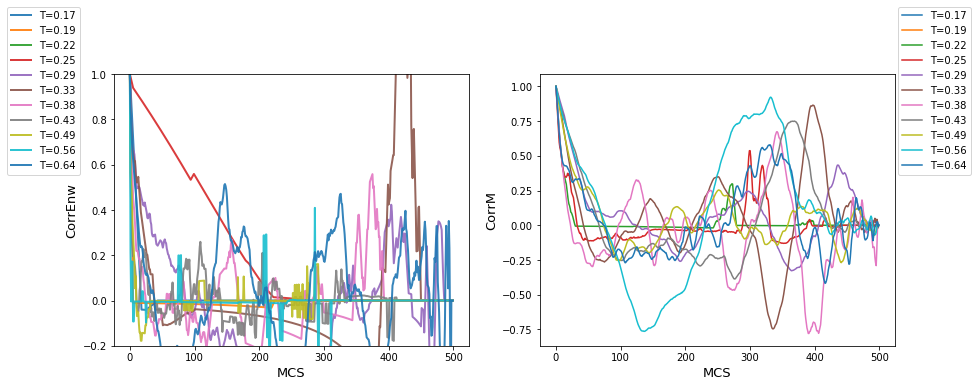

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
t = np.arange(len(LcorrEnw_data[3][0]))
i = 0 # index of scales
l = 4; k = 15

for j, item in enumerate(temperatures[l:k:]):
    ax1.plot(t,LcorrEnw_data[i][j+l], linewidth=2, label=('T={}'.format(np.around(item,2))), alpha=0.9)
    ax2.plot(t, LcorrMdata[i][j+l], label=('T={}'.format(np.around(item,2))))

    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('CorrEnw', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('CorrM', fontsize=13)
ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63))
ax1.set_ylim([-0.2,1])

print('L = %d'%(possibleScales[i]))
#print('Correlation time (decay length) of the energy(nng):', LtauEnw[i])
#print('Correlation time (decay length) of the magnetization:', LtauM[i])


### Average energy

In [28]:
#temperatures = np.geomspace(0.1, 8, 35)
print(temperatures)

new = False
if new:
    scales = []
    Len_nw_data = []; Len_nw_err = []
    Lmag_data = []; Lmag_err = []
    Lcol_data = []; Lcol_norm_data = []
    L_CvEnw_data = []; Lsusc_data = []
    
    # Save energy data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 
                'temperatures': temperatures, 'scales': scales}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))
    
    # Save magnetization data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))
    
    # Save collisions data as dictionary:
    nwpLdata_col = {'Lcol_data': Lcol_data, 'Lcol_norm_data': Lcol_norm_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_col, open('nwp1Dfinite_size_scaling_data_col.p', 'wb'))

[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [29]:
# Set system parameters (note that these are global!):
#scales = [64, 256, 784, 1024] # Lattice number
#temperatures = np.linspace(0.01, 8, 60) # Temperature (critical at around 0)
#temperatures = np.sort(np.random.normal(0.01,0.6,50))# Temperature (critical at around 0)

run = False

if run:
    N = 256; idx = 1
    t_eq = 1000
    t_prod = 1000
    t_sim = t_eq + t_prod
    
    en_nw_data = np.zeros(len(temperatures)); en_nw_err = np.zeros(len(temperatures))
    mag_data = np.zeros(len(temperatures)); mag_err = np.zeros(len(temperatures))
    col_data = np.zeros(len(temperatures)); col_norm_data = np.zeros(len(temperatures))
    
    CvEnw_data = np.zeros(len(temperatures)); susc_data = np.zeros(len(temperatures))

    # Initial lattice configuration
    lattice = -1*np.ones(N)  
    #lattice = np.random.choice([1,-1],size=N)
    
    results = Parallel(n_jobs=3, verbose=20)(delayed(simulate_eff)(lattice, T) for lattice,T in zip(LinitC[idx], temperatures))

    results1 = np.array(results).T
    for i,T in enumerate(temperatures):
        Enw = results1[1][i]; M = results1[2][i]; col = results1[3][i]; col_norm = results1[4][i]
        en_nw_data[i] = np.mean(Enw[t_eq:]); en_nw_err[i] = np.std(Enw[t_eq:])
        mag_data[i] = np.mean(abs(M[t_eq:])); mag_err[i] = np.std(abs(M[t_eq:]))
        col_data[i] = col; col_norm_data[i] = col_norm
    
        CvEnw_data[i] = specific_heat(Enw[t_eq:]); susc_data[i] = susceptiblity(abs(M[t_eq:]))
    
    '''for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
        # (only need first two values for metropolis)
        #A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, col, col_norm = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
        
        en_nw_data[j] = np.mean(Enw[t_eq:]); en_nw_err[j] = np.std(Enw[t_eq:])
        mag_data[j] = np.mean(abs(M[t_eq:])); mag_err[j] = np.std(abs(M[t_eq:]))
        col_data[j] = col; col_norm_data[j] = col_norm
 
        CvEnw_data[j] = specific_heat(Enw[t_eq:]); susc_data[j] = susceptiblity(abs(M[t_eq:]))
    '''

Len_nw_data[0] = en_nw_data; Len_nw_err[0] = en_nw_err; L_CvEnw_data[0] = CvEnw_data; Lmag_data[0] = mag_data
Lmag_err[0] = mag_err; Lsusc_data[0] = susc_data; Lcol_data[0] = col_data; Lcol_norm_data[0] = col_norm_data

In [30]:
nwpLdata = pickle.load(open('nwp1Dfinite_size_scaling_data.p', 'rb'))
Len_nw_data = nwpLdata['Len_nw_data']; Len_nw_err = nwpLdata['Len_nw_err']; L_CvEnw_data = nwpLdata['L_CvEnw_data']
temperatures = nwpLdata['temperatures']; scales = nwpLdata['scales']

nwpLdata_mag = pickle.load(open('nwp1Dfinite_size_scaling_data_mag.p', 'rb'))
Lmag_data= nwpLdata_mag['Lmag_data']; Lmag_err = nwpLdata_mag['Lmag_err']; Lsusc_data = nwpLdata_mag['Lsusc_data']

nwpLdata_col = pickle.load(open('nwp1Dfinite_size_scaling_data_col.p', 'rb'))
Lcol_data= nwpLdata_col['Lcol_data']; Lcol_norm_data = nwpLdata_col['Lcol_norm_data']

save = False
if save:
    scales.append(N)
    Len_nw_data.append(en_nw_data); Len_nw_err.append(en_nw_err)
    Lmag_data.append(mag_data); Lmag_err.append(mag_err)
    Lcol_data.append(col_data); Lcol_norm_data.append(col_norm_data)
    L_CvEnw_data.append(CvEnw_data); Lsusc_data.append(susc_data)
    
    # Save energy data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 
                'temperatures': temperatures, 'scales': scales}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))
    
    # Save magnetization data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))
    
    # Save collisions data as dictionary:
    nwpLdata_col = {'Lcol_data': Lcol_data, 'Lcol_norm_data': Lcol_norm_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_col, open('nwp1Dfinite_size_scaling_data_col.p', 'wb'))

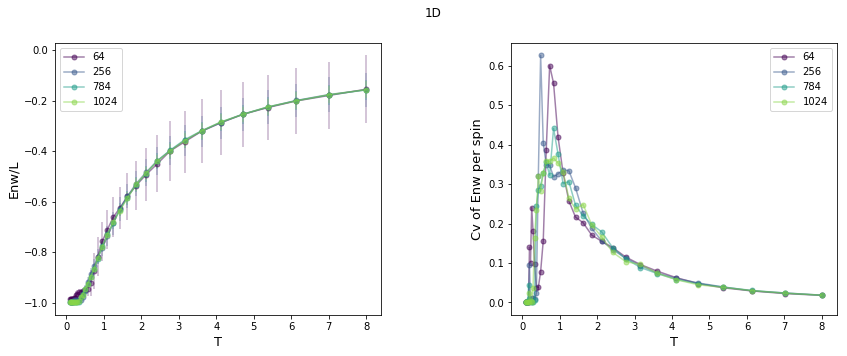

In [31]:
# Energy = number of nodes
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# energy:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('Enw/L', fontsize=13)#, color='y')
# specific heat:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('Cv of Enw per spin', fontsize=13)

for i,L in enumerate(scales):
    # energy:
    ax41.plot(temperatures, Len_nw_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Len_nw_data[i]/L, yerr=Len_nw_err[i]/L, alpha=0.3, linestyle='', color=cm.viridis(i*70))
    # specific heat:
    ax43.plot(temperatures, L_CvEnw_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 
                'temperatures': temperatures, 'scales': scales}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))

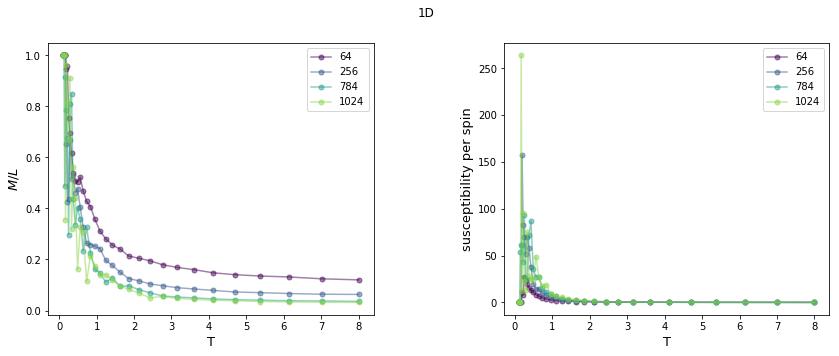

In [32]:
# magnetization ~ susceptibility
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# magnetization:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$M/L$', fontsize=13)#, color='y')

# susceptibility:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('susceptibility per spin', fontsize=13)

for i,L in enumerate(scales):
    # magnetization:
    ax41.plot(temperatures, Lmag_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    #ax41.errorbar(temperatures, Len_data[i], yerr=Len_err[i], alpha=0.3, linestyle='', color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lnng_data[i], yerr=Lnng_err[i], linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # susceptibility:
    ax43.plot(temperatures, Lsusc_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))

C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


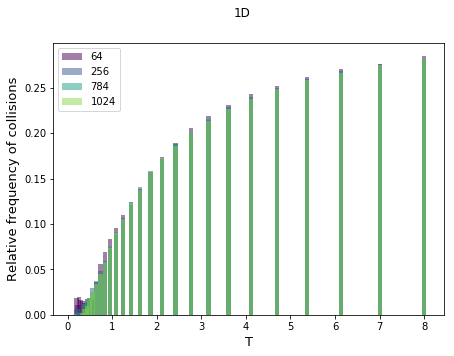

In [33]:
# relative frequency of collisions in averaging over spin domains procedure
%matplotlib inline
save = False
fig1 = plt.figure(figsize=(7,5)); fig1.suptitle('1D')
ax11 = fig1.add_subplot(1,1,1)

ax11.set_xlabel('T',fontsize=13)
ax11.set_ylabel('Relative frequency of collisions', fontsize=13, color='black')

for i,L in enumerate(scales):
    ax11.bar(temperatures, Lcol_data[i]/Lcol_norm_data[i], align='center', width=0.1, alpha=0.5, label='%d'%(L), 
             color=cm.viridis(i*70))
    
ax11.legend(loc='upper left')

if save:
    # Save data as dictionary:
    nwpLdata_col = {'Lcol_data': Lcol_data, 'Lcol_norm_data': Lcol_norm_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_col, open('nwp1Dfinite_size_scaling_data_col.p', 'wb'))

In [34]:
for i,L in enumerate(scales):
    print(L)
    print(np.sum(Lcol_data[i])/np.sum(Lcol_norm_data[i]))

64
0.20563142387479658
256
0.204259737807828
784
0.2039401045571798
1024
0.2035342475530177
